In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import CSVLogger
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# "failed to create cublas handle"
# と出る場合はGPUメモリの不足っぽいので制限してやればよい

# TensorFlowのGPUメモリ使用量の制限
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
set_session(tf.Session(config=config))

In [3]:
img_width = 150
img_height = 150
train_data_dir = "../data/butterflyfish/train"
val_data_dir = "../data/butterflyfish/validation/"

train_samples = 200
val_samples = 60
epochs = 100

In [4]:
input_tensor = Input(shape=(150, 150, 3))
vgg16_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [5]:
# vgg16_model.summary()

In [6]:
# VGGの下につなぐFC層を構築
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
# Flattenへの入力指定はbatch数を除いておく
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [7]:
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [8]:
model = Model(inputs=vgg16_model.input, outputs=top_model(vgg16_model.output))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [10]:
for layer in model.layers[:15]:
    layer.trainable = False

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [12]:
model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])

In [13]:
# データをつくる
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=90, width_shift_range=0.2, height_shift_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [14]:
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(150,150),
                                                    batch_size=32, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(val_data_dir, target_size=(150,150),
                                                    batch_size=32, class_mode='binary')

Found 200 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [15]:
print(train_generator.class_indices)

{'oriental': 0, 'threadfin': 1}


In [16]:
history = model.fit_generator(train_generator, epochs=epochs, verbose=1, validation_data=validation_generator)

Epoch 1/100
7/7 [==============================] - 5s 776ms/step - loss: 0.7746 - acc: 0.5136 - val_loss: 0.7252 - val_acc: 0.4667
Epoch 2/100
7/7 [==============================] - 1s 103ms/step - loss: 0.9128 - acc: 0.3833 - val_loss: 0.7129 - val_acc: 0.4833
Epoch 3/100
7/7 [==============================] - 1s 134ms/step - loss: 0.7385 - acc: 0.5208 - val_loss: 0.6960 - val_acc: 0.5500
Epoch 4/100
7/7 [==============================] - 1s 143ms/step - loss: 0.7379 - acc: 0.5155 - val_loss: 0.6829 - val_acc: 0.5167
Epoch 5/100
7/7 [==============================] - 1s 129ms/step - loss: 0.7615 - acc: 0.5181 - val_loss: 0.6751 - val_acc: 0.5500
Epoch 6/100
7/7 [==============================] - 1s 143ms/step - loss: 0.7365 - acc: 0.5291 - val_loss: 0.6619 - val_acc: 0.5833
Epoch 7/100
7/7 [==============================] - 1s 130ms/step - loss: 0.6718 - acc: 0.5906 - val_loss: 0.6482 - val_acc: 0.6833
Epoch 8/100
7/7 [==============================] - 1s 130ms/step - loss: 0.6310 - a

7/7 [==============================] - 1s 129ms/step - loss: 0.1908 - acc: 0.9430 - val_loss: 0.2998 - val_acc: 0.8333
Epoch 64/100
7/7 [==============================] - 1s 129ms/step - loss: 0.2004 - acc: 0.9294 - val_loss: 0.3153 - val_acc: 0.8333
Epoch 65/100
7/7 [==============================] - 1s 129ms/step - loss: 0.1654 - acc: 0.9547 - val_loss: 0.3106 - val_acc: 0.8333
Epoch 66/100
7/7 [==============================] - 1s 130ms/step - loss: 0.1732 - acc: 0.9230 - val_loss: 0.2980 - val_acc: 0.8333
Epoch 67/100
7/7 [==============================] - 1s 129ms/step - loss: 0.1913 - acc: 0.9158 - val_loss: 0.3009 - val_acc: 0.8333
Epoch 68/100
7/7 [==============================] - 1s 129ms/step - loss: 0.1754 - acc: 0.9430 - val_loss: 0.3146 - val_acc: 0.8333
Epoch 69/100
7/7 [==============================] - 1s 129ms/step - loss: 0.1659 - acc: 0.9339 - val_loss: 0.3146 - val_acc: 0.8333
Epoch 70/100
7/7 [==============================] - 1s 129ms/step - loss: 0.1823 - acc: 0

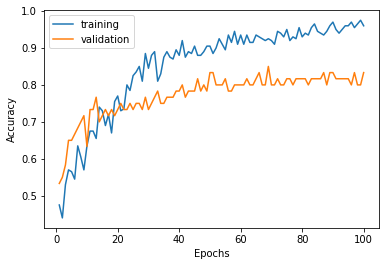

In [17]:
plt.plot(range(1, epochs+1), history.history['acc'], label="training")
plt.plot(range(1, epochs+1), history.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()